# Problem3

In [1]:
import os
import random
import math
import copy
import torch
import numpy as np
import torch.optim as optim
import torchvision.datasets as DS
import torch.utils.data as data
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)


# If in clolab environment or not
isColab = False


cuda


### Loading data

In [2]:
if not isColab:
    trainImageFolder = "./trainset/"
    testImageFolder = "./testset/"
else:
    # code here to fetch and load colab folders.
    noop()
    
BATCH_SIZE=512 

# Data augmentation is done through the Randomization of the transforms applied each time an image is loaded in the epoche.
# Each epoche will have different subset of transformations done on the images.
Transform_img = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine((10,10), translate=(0.1,0.1)),
    transforms.ToTensor()
])
tensor_img_transform = transforms.Compose([transforms.ToTensor()])

# Load from image folder directly, and assign the data augmentaion through the transform
full_dataset = DS.ImageFolder(root=trainImageFolder, transform=Transform_img)

# Seperate the training and validation set: 80% training, 20% validation
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_data, valid_data = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

train_loader = data.DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  
    num_workers=4,
    pin_memory=use_cuda
)

valid_loader = data.DataLoader(
    valid_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  
    num_workers=4,
    pin_memory=use_cuda
)

indices = list(range(len(train_data)))
random.shuffle(indices)
scratch_loader = data.DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    sampler=SubsetRandomSampler(indices[:64]),
    num_workers=1,
    pin_memory=use_cuda
)

### Validate format

This is the shape of one batch of inputs torch.Size([512, 3, 64, 64])
This is the shape of one batch of targets torch.Size([512])
This is an image of class tensor(1)


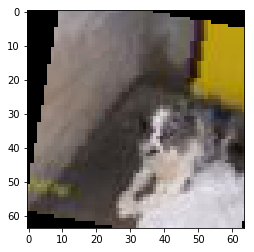

In [3]:
for step, (x, y) in enumerate(valid_loader):
    
    print(f"This is the shape of one batch of inputs {x.shape}")
    print(f"This is the shape of one batch of targets {y.shape}")
    print("This is an image of class", y[0])

    img = np.transpose(x[step].numpy(), (1, 2, 0)) # We actually want the chanels in the last column
    plt.imshow(img)
    break

### Model definitions
Heavely inspired from https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/ (MIT Liscence)
The BasicBlock is extracted from the repositery, but it's the building block for a resnet with bypass connections. The normalisations were removed since we were not allowed to use them whithout coding them ourselfs. 

In [4]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        #self.bn2 = nn.BatchNorm2d(planes)
        self.stride = stride
        
        self.downsample = None
        if inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride),
                # nn.BatchNorm2d(planes),
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        # out = self.bn2(out)
        
        # Reduce the sample size so the residual matches size
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class BasicNet(nn.Module):
    """Affordable convolutions for the people."""
    def initialize(self):
        nn.init.xavier_uniform_(self.fc1.weight.data)
        self.fc1.bias.data.zero_()
        nn.init.xavier_uniform_(self.fc2.weight.data)
        self.fc2.bias.data.zero_()
        
    def __init__(self):
        super().__init__()
        self.conv1 = conv3x3(3, 64, 2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=3, padding=1)
        
        self.layer1 = BasicBlock(64, 64)
        self.layer2= BasicBlock(64, 128, 2)
        self.layer3= BasicBlock(128, 128)
        self.layer4= BasicBlock(128, 256, 2)
        self.layer5= BasicBlock(256, 256)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(1024, 1)
        self.sm = nn.Sigmoid() # Because we are doing classification. We could use Sigmoid since this is a binary classification, 
        self.initialize()

    def forward(self, xin):
        x = self.conv1(xin)
       # x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer1(x)
        
        x = self.layer2(x)
        
        x = self.layer3(x)
        x = self.layer3(x)
        x = self.layer3(x)
        
        x = self.layer4(x)
        
        x = self.layer5(x)
        x = self.layer5(x)
        x = self.layer5(x)
        x = self.layer5(x)
        x = self.layer5(x)
        
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1) # flatten
        #x = self.fc1(x)
        #x = self.relu(x)
        x = self.fc2(x)
        #x = self.sm(x)
        
        return x
    

### Training

In [5]:
# Surrogate loss used for training
# If we were to use Softmax as our activation in our model, we should actually use Binary Cross Entropy Loss
# nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss() 
test_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')

# spot to save your learning curves, and potentially checkpoint your models
savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

## This method comes from the lab session number 11 of the class
def train(model, train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device) # Send data to the device
        target = target.view(-1,1).float()
        
        optimizer.zero_grad()
        output = model.forward(inputs)
        #print(output)
        #print(target.float())
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))

In [6]:
## This method comes from the lab session number 11 of the class
sigmoid_ = nn.Sigmoid()
def test(model, test_loader):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    
    with torch.no_grad(): # save some computations
      
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            target = target.view(-1,1).float()
            test_size += target.size(0)
            
            output = model(inputs)
            loss = test_loss_fn(output, target)
            test_loss += loss
            
            ## VERY IMPORTANT: when using BCEWithLogitsLoss, we have to pass the output in a Sigmoid since it was part of 
            ## BCEWithLogitsLoss when we did the backprop!
            pred = sigmoid_(output).round()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

### Overfitting capacity 
We want to validate we have the capacity to at least overfit a small number of examples to make sure our model is at least learning something. This also helps to determin the step size we should use for the longer learning cycles. 

In [33]:
overfit_model = BasicNet().to(device)

lr = 0.06
optimizer = optim.SGD(overfit_model.parameters(), lr=lr)

#results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
#savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 20):
    train(overfit_model, scratch_loader, optimizer, epoch)
    loss, acc = test(overfit_model, scratch_loader)


Train Epoch: 1 [0/64 (0%)]	Loss: 0.691052
Test set: Average loss: 0.6881, Accuracy: 29/64 (45%)

Train Epoch: 2 [0/64 (0%)]	Loss: 0.684949
Test set: Average loss: 0.6883, Accuracy: 29/64 (45%)

Train Epoch: 3 [0/64 (0%)]	Loss: 0.689665
Test set: Average loss: 0.6827, Accuracy: 29/64 (45%)

Train Epoch: 4 [0/64 (0%)]	Loss: 0.682900
Test set: Average loss: 0.6771, Accuracy: 29/64 (45%)

Train Epoch: 5 [0/64 (0%)]	Loss: 0.679085
Test set: Average loss: 0.6763, Accuracy: 29/64 (45%)

Train Epoch: 6 [0/64 (0%)]	Loss: 0.682479
Test set: Average loss: 0.6802, Accuracy: 29/64 (45%)

Train Epoch: 7 [0/64 (0%)]	Loss: 0.675027
Test set: Average loss: 0.6734, Accuracy: 29/64 (45%)

Train Epoch: 8 [0/64 (0%)]	Loss: 0.677751
Test set: Average loss: 0.6731, Accuracy: 29/64 (45%)

Train Epoch: 9 [0/64 (0%)]	Loss: 0.671319
Test set: Average loss: 0.6702, Accuracy: 29/64 (45%)

Train Epoch: 10 [0/64 (0%)]	Loss: 0.673701
Test set: Average loss: 0.6745, Accuracy: 30/64 (47%)

Train Epoch: 11 [0/64 (0%)]	L

In [7]:
model = BasicNet().to(device)

# 0.001 never learned
# 0.1 too mutch?
lr =  0.08
optimizer = optim.SGD(model.parameters(), lr=lr)

#results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
#savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )
best_model = None
best_acc = 0
train_losses = []
valid_losses = []
for epoch in range(1, 150):
    train(model, train_loader, optimizer, epoch)
    tr_loss, tr_acc = test(model, train_loader)
    loss, acc = test(model, valid_loader) 
    
    train_losses.append(tr_loss)
    valid_losses.append(loss)
    if (acc > best_acc):
        print("Best acc: ",acc)
        best_model = copy.deepcopy(model)
        best_acc = acc

Train Epoch: 1 [0/16384 (0%)]	Loss: 0.692094
Train Epoch: 1 [5120/16384 (31%)]	Loss: 0.688677
Train Epoch: 1 [10240/16384 (62%)]	Loss: 0.689064
Train Epoch: 1 [15360/16384 (94%)]	Loss: 0.689008
Test set: Average loss: 0.6946, Accuracy: 7979/15998 (50%)

Test set: Average loss: 0.6933, Accuracy: 2020/4000 (50%)

Best acc:  0.505
Train Epoch: 2 [0/16384 (0%)]	Loss: 0.699324
Train Epoch: 2 [5120/16384 (31%)]	Loss: 0.688041
Train Epoch: 2 [10240/16384 (62%)]	Loss: 0.680016
Train Epoch: 2 [15360/16384 (94%)]	Loss: 0.683472
Test set: Average loss: 0.7033, Accuracy: 7978/15998 (50%)

Test set: Average loss: 0.7008, Accuracy: 2020/4000 (50%)

Train Epoch: 3 [0/16384 (0%)]	Loss: 0.702659
Train Epoch: 3 [5120/16384 (31%)]	Loss: 0.681586
Train Epoch: 3 [10240/16384 (62%)]	Loss: 0.688747
Train Epoch: 3 [15360/16384 (94%)]	Loss: 0.684412
Test set: Average loss: 0.6861, Accuracy: 8453/15998 (53%)

Test set: Average loss: 0.6866, Accuracy: 2110/4000 (53%)

Best acc:  0.5275
Train Epoch: 4 [0/16384 (0

Train Epoch: 26 [5120/16384 (31%)]	Loss: 0.554731
Train Epoch: 26 [10240/16384 (62%)]	Loss: 0.635275
Train Epoch: 26 [15360/16384 (94%)]	Loss: 0.542301
Test set: Average loss: 0.5652, Accuracy: 11603/15998 (73%)

Test set: Average loss: 0.5627, Accuracy: 2900/4000 (72%)

Train Epoch: 27 [0/16384 (0%)]	Loss: 0.554264
Train Epoch: 27 [5120/16384 (31%)]	Loss: 0.542231
Train Epoch: 27 [10240/16384 (62%)]	Loss: 0.505774
Train Epoch: 27 [15360/16384 (94%)]	Loss: 0.529655
Test set: Average loss: 0.5412, Accuracy: 11612/15998 (73%)

Test set: Average loss: 0.5421, Accuracy: 2911/4000 (73%)

Best acc:  0.72775
Train Epoch: 28 [0/16384 (0%)]	Loss: 0.492780
Train Epoch: 28 [5120/16384 (31%)]	Loss: 0.567671
Train Epoch: 28 [10240/16384 (62%)]	Loss: 0.552133
Train Epoch: 28 [15360/16384 (94%)]	Loss: 0.539223
Test set: Average loss: 0.5215, Accuracy: 11936/15998 (75%)

Test set: Average loss: 0.5247, Accuracy: 2964/4000 (74%)

Best acc:  0.741
Train Epoch: 29 [0/16384 (0%)]	Loss: 0.512193
Train Epoc

Train Epoch: 51 [15360/16384 (94%)]	Loss: 0.476033
Test set: Average loss: 0.4534, Accuracy: 12681/15998 (79%)

Test set: Average loss: 0.4729, Accuracy: 3126/4000 (78%)

Train Epoch: 52 [0/16384 (0%)]	Loss: 0.472694
Train Epoch: 52 [5120/16384 (31%)]	Loss: 0.384551
Train Epoch: 52 [10240/16384 (62%)]	Loss: 0.421137
Train Epoch: 52 [15360/16384 (94%)]	Loss: 0.404066
Test set: Average loss: 0.4859, Accuracy: 12237/15998 (76%)

Test set: Average loss: 0.4906, Accuracy: 3067/4000 (77%)

Train Epoch: 53 [0/16384 (0%)]	Loss: 0.475589
Train Epoch: 53 [5120/16384 (31%)]	Loss: 0.442453
Train Epoch: 53 [10240/16384 (62%)]	Loss: 0.416138
Train Epoch: 53 [15360/16384 (94%)]	Loss: 0.418024
Test set: Average loss: 0.4543, Accuracy: 12545/15998 (78%)

Test set: Average loss: 0.4664, Accuracy: 3076/4000 (77%)

Train Epoch: 54 [0/16384 (0%)]	Loss: 0.454459
Train Epoch: 54 [5120/16384 (31%)]	Loss: 0.504435
Train Epoch: 54 [10240/16384 (62%)]	Loss: 0.418273
Train Epoch: 54 [15360/16384 (94%)]	Loss: 0.44


Best acc:  0.8395
Train Epoch: 77 [0/16384 (0%)]	Loss: 0.339888
Train Epoch: 77 [5120/16384 (31%)]	Loss: 0.310668
Train Epoch: 77 [10240/16384 (62%)]	Loss: 0.354304
Train Epoch: 77 [15360/16384 (94%)]	Loss: 0.328445
Test set: Average loss: 0.4121, Accuracy: 13003/15998 (81%)

Test set: Average loss: 0.4414, Accuracy: 3201/4000 (80%)

Train Epoch: 78 [0/16384 (0%)]	Loss: 0.396412
Train Epoch: 78 [5120/16384 (31%)]	Loss: 0.337065
Train Epoch: 78 [10240/16384 (62%)]	Loss: 0.365776
Train Epoch: 78 [15360/16384 (94%)]	Loss: 0.310031
Test set: Average loss: 0.4198, Accuracy: 12882/15998 (81%)

Test set: Average loss: 0.4340, Accuracy: 3175/4000 (79%)

Train Epoch: 79 [0/16384 (0%)]	Loss: 0.427203
Train Epoch: 79 [5120/16384 (31%)]	Loss: 0.351880
Train Epoch: 79 [10240/16384 (62%)]	Loss: 0.282312
Train Epoch: 79 [15360/16384 (94%)]	Loss: 0.352752
Test set: Average loss: 0.4303, Accuracy: 12771/15998 (80%)

Test set: Average loss: 0.4519, Accuracy: 3124/4000 (78%)

Train Epoch: 80 [0/16384 (0

Train Epoch: 102 [15360/16384 (94%)]	Loss: 0.266957
Test set: Average loss: 0.3247, Accuracy: 13708/15998 (86%)

Test set: Average loss: 0.3994, Accuracy: 3335/4000 (83%)

Train Epoch: 103 [0/16384 (0%)]	Loss: 0.309451
Train Epoch: 103 [5120/16384 (31%)]	Loss: 0.230621
Train Epoch: 103 [10240/16384 (62%)]	Loss: 0.269604
Train Epoch: 103 [15360/16384 (94%)]	Loss: 0.316553
Test set: Average loss: 0.4020, Accuracy: 12961/15998 (81%)

Test set: Average loss: 0.4425, Accuracy: 3154/4000 (79%)

Train Epoch: 104 [0/16384 (0%)]	Loss: 0.395457
Train Epoch: 104 [5120/16384 (31%)]	Loss: 0.249107
Train Epoch: 104 [10240/16384 (62%)]	Loss: 0.224629
Train Epoch: 104 [15360/16384 (94%)]	Loss: 0.303205
Test set: Average loss: 0.3366, Accuracy: 13548/15998 (85%)

Test set: Average loss: 0.3824, Accuracy: 3319/4000 (83%)

Train Epoch: 105 [0/16384 (0%)]	Loss: 0.372062
Train Epoch: 105 [5120/16384 (31%)]	Loss: 0.232591
Train Epoch: 105 [10240/16384 (62%)]	Loss: 0.252293
Train Epoch: 105 [15360/16384 (94%


Test set: Average loss: 0.3668, Accuracy: 3357/4000 (84%)

Train Epoch: 128 [0/16384 (0%)]	Loss: 0.260757
Train Epoch: 128 [5120/16384 (31%)]	Loss: 0.274781
Train Epoch: 128 [10240/16384 (62%)]	Loss: 0.320677
Train Epoch: 128 [15360/16384 (94%)]	Loss: 0.219513
Test set: Average loss: 0.3232, Accuracy: 13715/15998 (86%)

Test set: Average loss: 0.4323, Accuracy: 3310/4000 (83%)

Train Epoch: 129 [0/16384 (0%)]	Loss: 0.334297
Train Epoch: 129 [5120/16384 (31%)]	Loss: 0.232634
Train Epoch: 129 [10240/16384 (62%)]	Loss: 0.184504
Train Epoch: 129 [15360/16384 (94%)]	Loss: 0.188195
Test set: Average loss: 0.2801, Accuracy: 14091/15998 (88%)

Test set: Average loss: 0.3751, Accuracy: 3362/4000 (84%)

Train Epoch: 130 [0/16384 (0%)]	Loss: 0.252715
Train Epoch: 130 [5120/16384 (31%)]	Loss: 0.231156
Train Epoch: 130 [10240/16384 (62%)]	Loss: 0.221261
Train Epoch: 130 [15360/16384 (94%)]	Loss: 0.210346
Test set: Average loss: 0.2205, Accuracy: 14504/15998 (91%)

Test set: Average loss: 0.3415, A

### more training...

In [19]:
lr = 0.0005
optimizer = optim.SGD(model.parameters(), lr=lr)

more_train_losses = []
more_valid_losses = []
for epoch in range(1, 30):
    train(model, train_loader, optimizer, epoch)
    tr_loss, tr_acc = test(model, train_loader)
    loss, acc = test(model, valid_loader) 
    
    more_train_losses.append(tr_loss)
    more_valid_losses.append(loss)
    
    if (acc > best_acc):
        print("Best acc: ",acc)
        best_model = copy.deepcopy(model)
        best_acc = acc

Train Epoch: 1 [0/16384 (0%)]	Loss: 0.031841
Train Epoch: 1 [5120/16384 (31%)]	Loss: 0.073640
Train Epoch: 1 [10240/16384 (62%)]	Loss: 0.033798
Train Epoch: 1 [15360/16384 (94%)]	Loss: 0.049215
Test set: Average loss: 0.0333, Accuracy: 15798/15998 (99%)

Test set: Average loss: 0.5582, Accuracy: 3529/4000 (88%)

Train Epoch: 2 [0/16384 (0%)]	Loss: 0.040717
Train Epoch: 2 [5120/16384 (31%)]	Loss: 0.057396
Train Epoch: 2 [10240/16384 (62%)]	Loss: 0.026375
Train Epoch: 2 [15360/16384 (94%)]	Loss: 0.019762
Test set: Average loss: 0.0377, Accuracy: 15763/15998 (99%)

Test set: Average loss: 0.5504, Accuracy: 3530/4000 (88%)

Train Epoch: 3 [0/16384 (0%)]	Loss: 0.029647
Train Epoch: 3 [5120/16384 (31%)]	Loss: 0.040281
Train Epoch: 3 [10240/16384 (62%)]	Loss: 0.039540
Train Epoch: 3 [15360/16384 (94%)]	Loss: 0.033525
Test set: Average loss: 0.0379, Accuracy: 15761/15998 (99%)

Test set: Average loss: 0.5559, Accuracy: 3516/4000 (88%)

Train Epoch: 4 [0/16384 (0%)]	Loss: 0.035403
Train Epoch: 


Train Epoch: 27 [0/16384 (0%)]	Loss: 0.027341
Train Epoch: 27 [5120/16384 (31%)]	Loss: 0.042077
Train Epoch: 27 [10240/16384 (62%)]	Loss: 0.032524
Train Epoch: 27 [15360/16384 (94%)]	Loss: 0.030273
Test set: Average loss: 0.0322, Accuracy: 15796/15998 (99%)

Test set: Average loss: 0.6062, Accuracy: 3515/4000 (88%)

Train Epoch: 28 [0/16384 (0%)]	Loss: 0.019633
Train Epoch: 28 [5120/16384 (31%)]	Loss: 0.021080
Train Epoch: 28 [10240/16384 (62%)]	Loss: 0.043452
Train Epoch: 28 [15360/16384 (94%)]	Loss: 0.048397
Test set: Average loss: 0.0317, Accuracy: 15794/15998 (99%)

Test set: Average loss: 0.6188, Accuracy: 3504/4000 (88%)

Train Epoch: 29 [0/16384 (0%)]	Loss: 0.024534
Train Epoch: 29 [5120/16384 (31%)]	Loss: 0.043656
Train Epoch: 29 [10240/16384 (62%)]	Loss: 0.022411
Train Epoch: 29 [15360/16384 (94%)]	Loss: 0.025659
Test set: Average loss: 0.0332, Accuracy: 15797/15998 (99%)

Test set: Average loss: 0.6105, Accuracy: 3504/4000 (88%)



In [18]:
print(best_acc)

0.8895


### Learning graphs

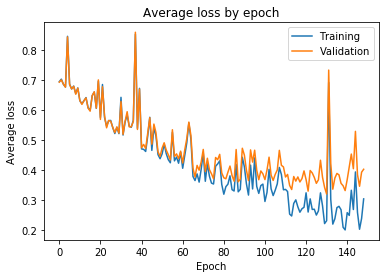

In [14]:
plt.plot(np.arange(0,len(train_losses),1), train_losses, label="Training")
plt.plot(np.arange(0,len(valid_losses),1), valid_losses, label="Validation")
plt.title("Average loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.legend()
plt.show()

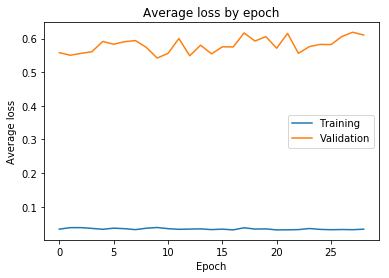

In [20]:
plt.plot(np.arange(0,len(more_train_losses),1), more_train_losses, label="Training")
plt.plot(np.arange(0,len(more_valid_losses),1), more_valid_losses, label="Validation")
plt.title("Average loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.legend()
plt.show()

### Saving Model

In [160]:
import datetime
date = datetime.date.today().strftime("%B %d, %Y")
best_model.to("cpu")
torch.save(best_model, "best_model_" + date + ".pt")
torch.save(best_model.state_dict(), "best_model_dict_" + date + ".pt")
best_model.to(device)

C:\Users\Game\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BasicNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Game\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


BasicNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    )
  )
  (layer3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1

### Optional: loading a model
Just un-comment the necessary lines

In [ ]:

### Load entire model
# loaded_model = torch.load("./best_model_January 30, 2019.pt")
# loaded_model.eval()
# loaded_model.to(device)

### Or, Load state_dict
# model = BasicNet()
# model.load_state_dict("./best_model_dict_January 30, 2019.pt")
# model.eval()
# loaded_model.to(device)


### Generate testing output

In [11]:
testImageFolder = "./testset/"

test_official = DS.ImageFolder(root=testImageFolder, transform=tensor_img_transform)
test_loader_off = data.DataLoader(
    test_official,
    batch_size=1,
    # The sampler is an easy way to say that we're using the elements
    num_workers=1,
    pin_memory=True # Cuda
)
final_results = []
ouput_file = open("finalResults2.csv", "w")
# writre headers
ouput_file.write("id,label\n")
for idx, (img, label)  in enumerate(test_loader_off):
    inputs = img.to(device)

    output = best_model(inputs)

    pred = sigmoid_(output).round()
    class_name_pred = full_dataset.classes[pred.int()]
    # get the file name
    path, filename = os.path.split(test_official.imgs[idx][0]) # (img path, label), no labels for tests, so we want arg[0]
    filename, extension = filename.split(".")
    # save the results
    final_results.append([filename, class_name_pred])
    ouput_file.write(str(filename) + "," + class_name_pred + "\n")
    

ouput_file.close()